# Video Script Generation with AI-Generated Images

In this notebook, we'll create a complete workflow for generating educational video scripts about research papers, including AI-generated visual elements.

## What You'll Learn
- How to use the OpenAI Responses API to generate structured video scripts
- How to create image prompts for educational visuals
- How to generate images using OpenAI's Image Generation API
- How to combine text and visuals for video content

## Use Case
Creating educational videos about research papers requires:
1. A well-structured script that explains complex concepts simply
2. Visual aids that help illustrate key ideas
3. Scene-by-scene planning for video production

Let's automate this process using AI!

## Setup

First, we'll import the necessary libraries and set up our OpenAI client.

In [1]:
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List
from pypdf import PdfReader
import base64
from IPython.display import Image, display, Markdown

# Initialize the OpenAI client
client = OpenAI()

## Define the Video Script Structure

We'll use Pydantic to define what a video script should contain. This ensures our AI generates well-structured output.

In [2]:
class ScriptScene(BaseModel):
    """Represents a single scene in the video script."""
    scene_number: int = Field(description="The scene number (1, 2, 3, etc.)")
    narration: str = Field(description="What the narrator says in this scene (1-3 sentences)")
    image_prompt: str = Field(description="Detailed prompt for generating a visual for this scene")

class VideoScript(BaseModel):
    """Complete video script with title and scenes."""
    title: str = Field(description="Catchy title for the video")
    hook: str = Field(description="Opening hook to grab attention (1 sentence)")
    scenes: List[ScriptScene] = Field(description="List of 4-5 scenes that explain the paper")
    conclusion: str = Field(description="Closing statement (1-2 sentences)")

## Load a Research Paper

We'll use a helper function to extract text from a PDF research paper.

In [3]:
def load_pdf_text(file_path):
    """Loads text from a PDF file."""
    reader = PdfReader(file_path)
    text = "\n\n".join([page.extract_text() for page in reader.pages])
    return text

# Load the Word2Vec paper
paper_text = load_pdf_text("../assets/paper3.pdf")

print(f"Loaded paper with {len(paper_text)} characters")
print(f"First 200 characters: {paper_text[:200]}...")

Loaded paper with 38768 characters
First 200 characters: Efﬁcient Estimation of Word Representations in
Vector Space
Tomas Mikolov
Google Inc., Mountain View, CA
tmikolov@google.com
Kai Chen
Google Inc., Mountain View, CA
kaichen@google.com
Greg Corrado
Goo...


## Generate the Video Script

Now we'll use the Responses API with structured outputs to generate a complete video script.

In [4]:
# Create instructions for the AI
instructions = """
You are an expert at creating educational video scripts about research papers.
Your scripts should be:
- Simple and engaging for a general audience
- Clear and easy to follow
- Visual-friendly (describe what viewers should see)
"""

# Generate the script using structured outputs
response = client.responses.parse(
    model="gpt-5-mini",
    instructions=instructions,
    input=f"Create a 60-second educational video script about this research paper. Make it engaging and visual:\n\n{paper_text}",
    text_format=VideoScript
)

# Extract the structured script
script = response.output_parsed

print(f"Generated script: '{script.title}'")
print(f"Number of scenes: {len(script.scenes)}")

Generated script: 'How Word2Vec Learned the Meaning of Words (in Minutes, Not Months)'
Number of scenes: 5


## Display the Script

Let's see what the AI generated!

In [5]:
# Format the script as markdown
script_md = f"""
# {script.title}

## Opening Hook
{script.hook}

## Scenes
"""

for scene in script.scenes:
    script_md += f"""
### Scene {scene.scene_number}
**Narration:** {scene.narration}

**Visual:** {scene.image_prompt}

---
"""

script_md += f"""
## Conclusion
{script.conclusion}
"""

display(Markdown(script_md))


# How Word2Vec Learned the Meaning of Words (in Minutes, Not Months)

## Opening Hook
What if a computer could place words on a map so 'king' sits near 'queen' — and learn this from billions of words in a day?

## Scenes

### Scene 1
**Narration:** Traditional NLP treats words as meaningless IDs — like colored pegs — so 'cat' and 'feline' look nothing alike to a machine. Mikolov and colleagues instead teach machines to embed words as vectors, giving them positions in a continuous space that reveal meaning.

**Visual:** Split-screen: left side shows a grid of labeled squares with IDs (e.g., 'w_423', 'w_19') cold and disconnected; right side morphs into a colorful 2D scatterplot with labeled points ('cat', 'dog', 'feline') clustered together. Use simple, bold typography and animated arrows showing 'IDs' -> 'vectors'.

---

### Scene 2
**Narration:** They introduce two tiny, fast neural models — CBOW (predict a word from its context) and Skip-gram (predict context words from a word) — that skip heavy hidden layers to train on huge corpora quickly.

**Visual:** Animated diagram: two simplified network sketches side-by-side. Left: CBOW — several context words feeding into an averaged vector node, pointing to predicted middle word. Right: Skip-gram — one input word projecting outward to several predicted context words. Use bright icons for words and light traces for the prediction signals; label each architecture clearly.

---

### Scene 3
**Narration:** The magic: simple vector math encodes relationships — vector('king') − vector('man') + vector('woman') lands near vector('queen'). These linear regularities pop out naturally from training.

**Visual:** 3D-looking vector visualization: points for 'king', 'man', 'woman', and 'queen'. Show an animated arrow: king -> subtract man (arrow) -> add woman -> lands near queen. Overlay the equation text briefly and use a glowing highlight on 'queen' as the target.

---

### Scene 4
**Narration:** Because the models are log-linear and computationally cheap, they trained on billions of words in hours or days, producing high-quality vectors that beat earlier, slower approaches.

**Visual:** Timelapse-style montage: racks of servers, progress bars speeding across, then a chart popping up comparing training time and accuracy (Skip-gram/CBOW much faster and higher). Use clean bars and labels: 'Data: billions of words', 'Time: hours vs weeks', 'Accuracy: higher'.

---

### Scene 5
**Narration:** These compact word vectors powered improvements across NLP — from translation and search to question answering — and became a foundation for many language tools today.

**Visual:** Collage of app icons and mini-scenes: a translation app swapping languages, a search box returning relevant results, a chatbot answering a question. Lines connect each app to a central glowing 'word vector' orb to show impact.

---

## Conclusion
Mikolov et al.'s CBOW and Skip-gram made learning meaningful word representations fast and scalable — turning massive text into a geometry of meaning that modern language AI still builds on.


## Generate Images for Each Scene

Now we'll use OpenAI's Image Generation API to create visuals for each scene in our script.

In [6]:
def generate_scene_image(scene, output_folder="../assets/video_images"):
    """
    Generate an image for a video scene using DALL-E.
    
    Args:
        scene: ScriptScene object with image_prompt
        output_folder: Where to save the generated images
    
    Returns:
        Path to the saved image file
    """
    import os
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    print(f"Generating image for Scene {scene.scene_number}...")
    
    # Generate the image
    img_response = client.images.generate(
        model="gpt-image-1",
        prompt=scene.image_prompt,
        n=1,
        size="1024x1024"
    )
    
    # Decode and save the image
    image_bytes = base64.b64decode(img_response.data[0].b64_json)
    output_path = f"{output_folder}/scene_{scene.scene_number}.png"
    
    with open(output_path, "wb") as f:
        f.write(image_bytes)
    
    print(f"✓ Saved to {output_path}")
    return output_path

# Generate images for all scenes
image_paths = []
for scene in script.scenes:
    path = generate_scene_image(scene)
    image_paths.append(path)

print(f"\nGenerated {len(image_paths)} images!")

Generating image for Scene 1...
✓ Saved to ../assets/video_images/scene_1.png
Generating image for Scene 2...
✓ Saved to ../assets/video_images/scene_2.png
Generating image for Scene 3...
✓ Saved to ../assets/video_images/scene_3.png
Generating image for Scene 4...
✓ Saved to ../assets/video_images/scene_4.png
Generating image for Scene 5...
✓ Saved to ../assets/video_images/scene_5.png

Generated 5 images!


## View the Complete Video Storyboard

Let's see our script with the generated images!

VIDEO STORYBOARD: How Word2Vec Learned the Meaning of Words (in Minutes, Not Months)

OPENING HOOK: What if a computer could place words on a map so 'king' sits near 'queen' — and learn this from billions of words in a day?


SCENE 1
Narration: Traditional NLP treats words as meaningless IDs — like colored pegs — so 'cat' and 'feline' look nothing alike to a machine. Mikolov and colleagues instead teach machines to embed words as vectors, giving them positions in a continuous space that reveal meaning.



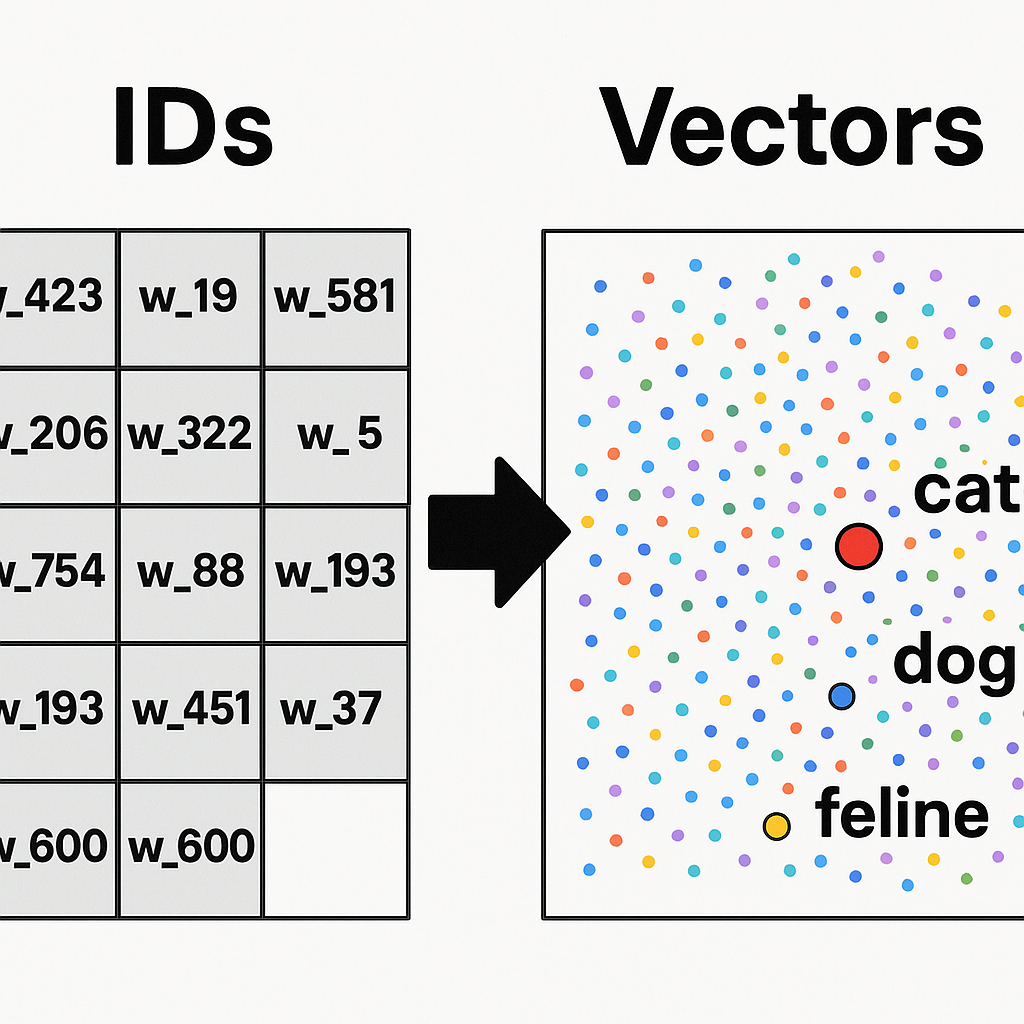



SCENE 2
Narration: They introduce two tiny, fast neural models — CBOW (predict a word from its context) and Skip-gram (predict context words from a word) — that skip heavy hidden layers to train on huge corpora quickly.



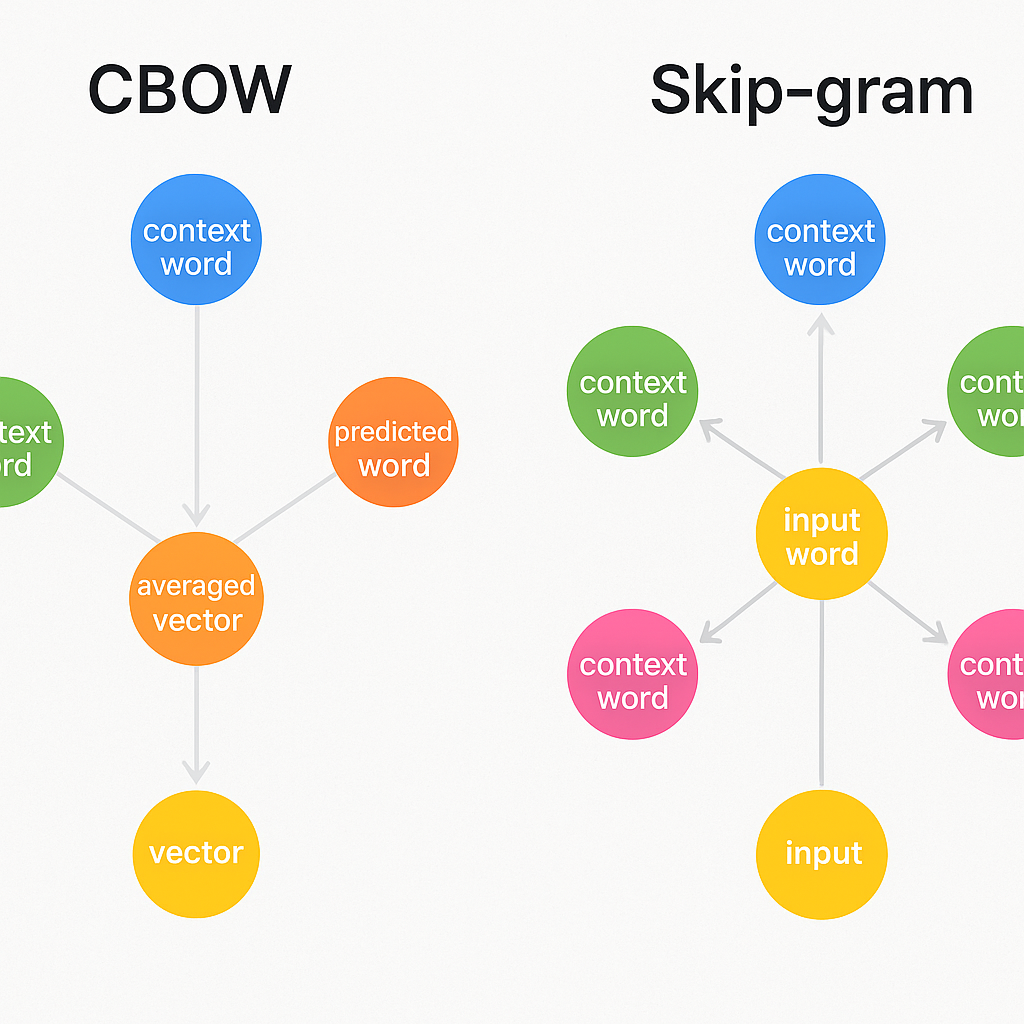



SCENE 3
Narration: The magic: simple vector math encodes relationships — vector('king') − vector('man') + vector('woman') lands near vector('queen'). These linear regularities pop out naturally from training.



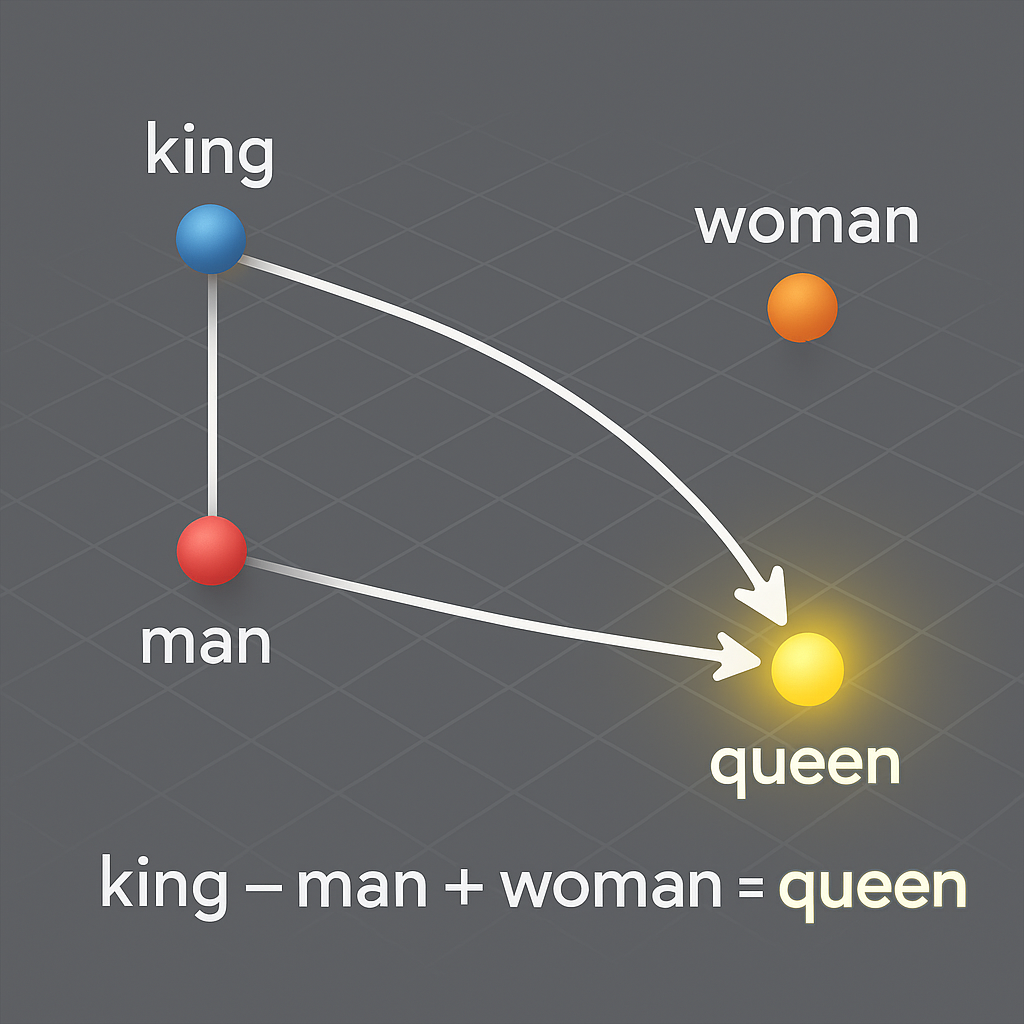



SCENE 4
Narration: Because the models are log-linear and computationally cheap, they trained on billions of words in hours or days, producing high-quality vectors that beat earlier, slower approaches.



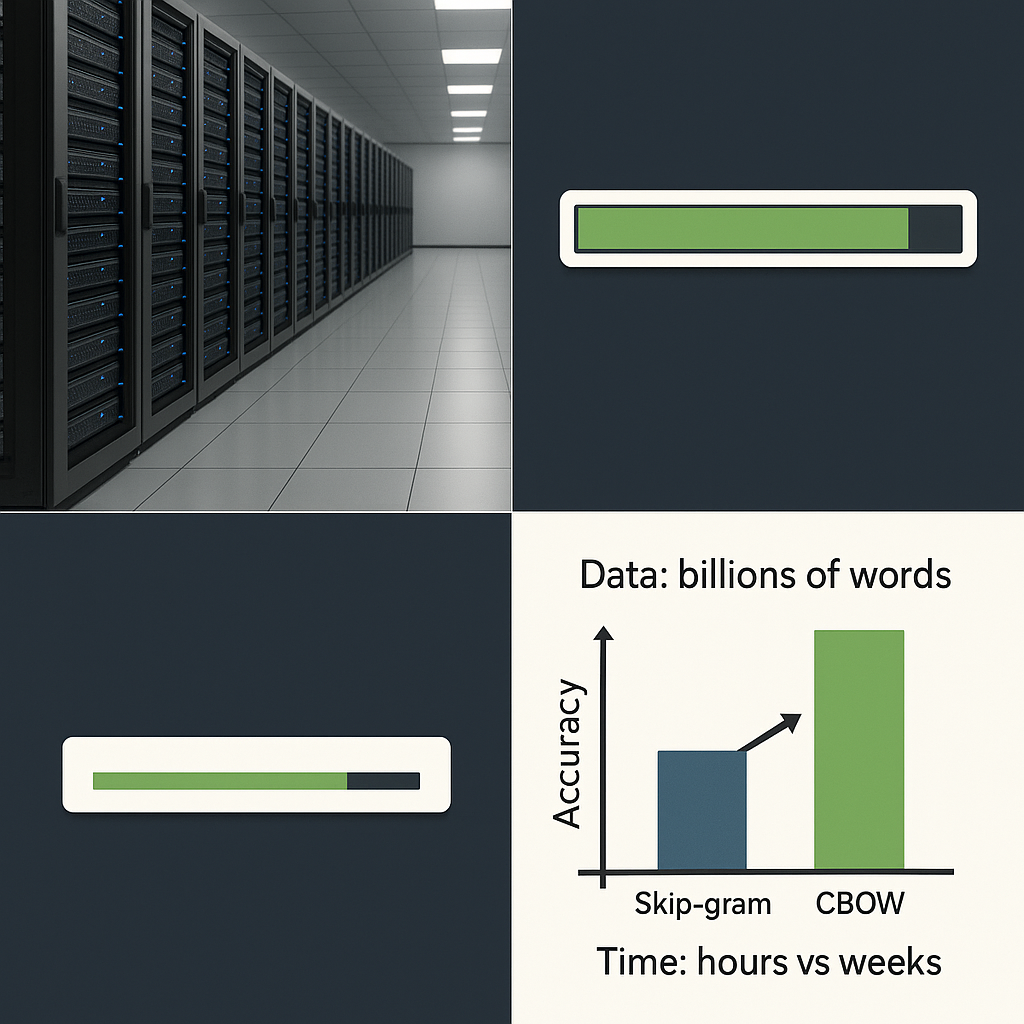



SCENE 5
Narration: These compact word vectors powered improvements across NLP — from translation and search to question answering — and became a foundation for many language tools today.



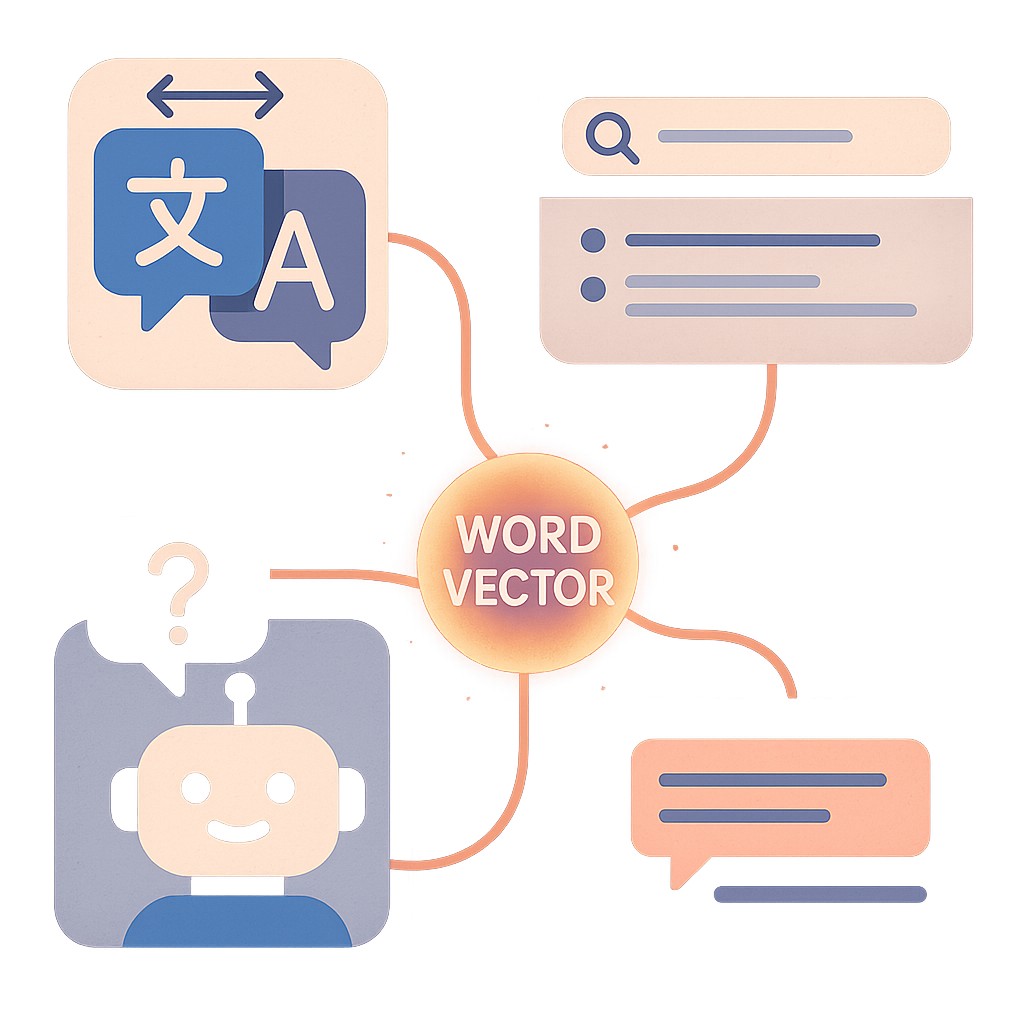



CONCLUSION: Mikolov et al.'s CBOW and Skip-gram made learning meaningful word representations fast and scalable — turning massive text into a geometry of meaning that modern language AI still builds on.


In [7]:
# Display the complete storyboard
print(f"VIDEO STORYBOARD: {script.title}")
print("=" * 80)
print(f"\nOPENING HOOK: {script.hook}\n")

for scene, img_path in zip(script.scenes, image_paths):
    print(f"\n{'='*80}")
    print(f"SCENE {scene.scene_number}")
    print(f"{'='*80}")
    print(f"Narration: {scene.narration}\n")
    display(Image(filename=img_path, width=400))
    print()

print(f"\n{'='*80}")
print(f"CONCLUSION: {script.conclusion}")
print("=" * 80)

## Key Takeaways

In this notebook, you learned:

1. **Structured Outputs**: Using Pydantic models with `responses.parse()` ensures the AI generates exactly the format you need
2. **Image Generation**: The `images.generate()` API creates custom visuals from text descriptions
3. **Workflow Automation**: Combining text and image generation creates a complete content pipeline

## Next Steps

Try modifying this notebook to:
- Generate scripts for different paper types
- Adjust the number of scenes
- Experiment with different image styles in the prompts
- Add voice-over timing to each scene